In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version
import matplotlib

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='random.gsd')



In [4]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [5]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=periodic,
    moves=['d'],
    target=0.2,
    max_translation_move=1,
)
simulation.operations.tuners.append(tune)

In [6]:
rho = simulation.state.N_particles / simulation.state.box.volume
rho 

0.09329446064139942

In [7]:
initial_volume = simulation.state.N_particles / rho
initial_volume

1157.625

In [8]:
# 3 - 0.1515

In [9]:
final_rho = 0.1525
final_volume = simulation.state.N_particles / final_rho
final_volume

708.1967213114755

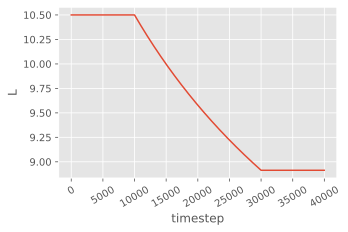

In [10]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)

steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

In [11]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp, 
)
simulation.operations.updaters.append(box_resize)

In [12]:
simulation.run(20001)

In [13]:
current_rho = simulation.state.N_particles / simulation.state.box.volume
current_rho

0.15249999999999997

In [14]:
mc.type_shapes

[{'type': 'Sphere', 'diameter': 2}]

In [15]:
# render(simulation.state.get_snapshot())

In [16]:
mc.overlaps

2

In [17]:
L_new = (simulation.state.box.volume) ** (1/3) 
print(f"New Box Length:", L_new)

New Box Length: 8.913562293191577


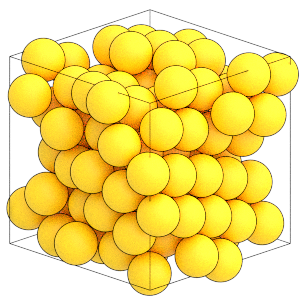

In [18]:
render(simulation.state.get_snapshot())

In [19]:
simulation.operations.updaters.remove(box_resize)

In [20]:
simulation.operations.tuners.remove(tune)

In [21]:
simulation.run(5e5)

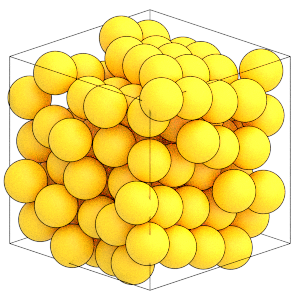

In [22]:
render(simulation.state.get_snapshot())

In [23]:
fn = os.path.join(os.getcwd(), 'compressed.gsd')
![ -e "$fn" ] && rm "$fn"

hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='compressed.gsd')